# LSTM(Baseline)

Model : LSTM

Data : KOSDAQ 2020.01.01 ~ 2024.04.30 / 2020년 1월 1일 기준 시총 100억~ 200억만 활용 <br/>
Imbalanced Data : class_weight

Feature : '시가', '고가', '저가', '종가', '거래량'

Scaler : Standard

## Data Load

In [1]:
import pandas as pd
import numpy as np
from pykrx import stock
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [2]:
# 파일 경로
file_path = '/Users/yangdong-yeong/Desktop/Fnguide/data/kosdaq_2020~2024.csv'

# CSV 파일 불러오기
df = pd.read_csv(file_path)

# 'ticker' 열의 값을 문자열로 변환하고, 5자리인 경우 앞에 '0'을 추가
df['ticker'] = df['ticker'].astype(str).str.zfill(6)

# 변경된 데이터 확인
print(df.head(5))

/var/folders/h0/rz02629x2b535_x0qf1h70zm0000gn/T/ipykernel_34693/2171151300.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


           날짜    시가    고가    저가    종가     거래량       등락률  ticker
0  2020-01-02  2820  2845  2780  2795  131742 -0.886525  060310
1  2020-01-03  2795  2825  2775  2810  100374  0.536673  060310
2  2020-01-06  2800  2805  2650  2685  201779 -4.448399  060310
3  2020-01-07  2685  2745  2685  2745   62241  2.234637  060310
4  2020-01-08  2720  2745  2580  2585  203909 -5.828780  060310


In [3]:
df.shape

(1597711, 8)

In [4]:
# 시가총액 데이터 가져오기
market_cap_df = stock.get_market_cap("20200102")  # 2020년 1월 1일 데이터

# 100억 이상 200억 이하인 종목 필터링
market_cap_df = market_cap_df[(market_cap_df['시가총액'] >= 10000000000) & (market_cap_df['시가총액'] <= 20000000000)]

# 원본 데이터셋 (예를 들어 'df')에서 시가총액 100억 이상 200억 이하인 종목만 추출
filtered_tickers = market_cap_df.index
df = df[df['ticker'].isin(filtered_tickers)]

## Data Processing

In [5]:
#날짜 포맷 확인 및 변환
df['날짜'] = pd.to_datetime(df['날짜'])

# ticker 별로 데이터 분할
tickers = tickers = df['ticker'].unique()
ticker_df = {ticker: df[df['ticker'] == ticker] for ticker in tickers}

In [6]:
ticker_df

{'013720':              날짜    시가    고가    저가    종가      거래량       등락률  ticker
 7483 2020-01-02  1200  1220  1190  1220    76643  1.666667  013720
 7484 2020-01-03  1200  1220  1200  1210    44632 -0.819672  013720
 7485 2020-01-06  1200  1220  1190  1220    66382  0.826446  013720
 7486 2020-01-07  1190  1200  1180  1190    93389 -2.459016  013720
 7487 2020-01-08  1180  1190  1140  1140   116496 -4.201681  013720
 ...         ...   ...   ...   ...   ...      ...       ...     ...
 8547 2024-04-24  1378  1450  1360  1380   121172  0.290698  013720
 8548 2024-04-25  1419  1419  1335  1347   213124 -2.391304  013720
 8549 2024-04-26  1347  1380  1331  1361   156230  1.039347  013720
 8550 2024-04-29  1361  1380  1347  1360   147861 -0.073475  013720
 8551 2024-04-30  1360  1610  1343  1474  1289682  8.382353  013720
 
 [1069 rows x 8 columns],
 '222160':               날짜    시가    고가    저가    종가   거래량        등락률  ticker
 76649 2020-01-02  2000  2000  2000  2000     0  -4.761905  222160
 7

In [7]:
# 스케일링
scalers = {ticker: StandardScaler() for ticker in tickers}

for ticker in tickers:
    df_copy = ticker_df[ticker].copy()
    df_copy[['시가', '고가', '저가', '종가', '거래량']] = df_copy[['시가', '고가', '저가', '종가', '거래량']].astype(float)
    
    # 데이터 스케일링
    scaled_data = scalers[ticker].fit_transform(df_copy[['시가', '고가', '저가', '종가', '거래량']])
    
    # 스케일된 데이터를 DataFrame으로 만들고, 원본과 같은 데이터 형식(int)으로 캐스팅합니다.
    scaled_df = pd.DataFrame(scaled_data, columns=['시가', '고가', '저가', '종가', '거래량'], index=df_copy.index)
    for col in ['시가', '고가', '저가', '종가', '거래량']:
        # 원본 데이터의 데이터 타입에 맞춰 캐스팅합니다.
        scaled_df[col] = scaled_df[col].astype(ticker_df[ticker][col].dtype)

    # 스케일된 데이터를 원본 DataFrame에 적용
    ticker_df[ticker].loc[:, ['시가', '고가', '저가', '종가', '거래량']] = scaled_df

# 메모리 문제로 파일 중간 저장
all_data = pd.concat([ticker_df[ticker] for ticker in tickers], axis=0, ignore_index=True)
all_data.to_csv('/Users/yangdong-yeong/Desktop/Fnguide/data/kosdaq_100억~200억_scaled.csv', index=False)

In [8]:
# CSV 파일 불러오기
file_path = '/Users/yangdong-yeong/Desktop/Fnguide/data/kosdaq_100억~200억_scaled.csv'
ticker_df = pd.read_csv(file_path)

# '날짜' 열을 datetime 객체로 변환
ticker_df['날짜'] = pd.to_datetime(ticker_df['날짜'])

# ticker 별로 데이터 분할
tickers = ticker_df['ticker'].unique()
ticker_data = {ticker: ticker_df[ticker_df['ticker'] == ticker] for ticker in tickers}

In [9]:
# 시퀀스 데이터와 레이블 생성 함수
def create_sequences_and_labels(df, sequence_length, threshold=20, look_forward=30):
    sequences = []
    labels = []
    if len(df) >= sequence_length + look_forward:

        for i in range(len(df) - sequence_length - look_forward + 1):
            sequence_start = i
            sequence_end = i + sequence_length
            future_start = sequence_end
            future_end = future_start + look_forward

            sequences.append(df[['시가', '고가', '저가', '종가', '거래량']].iloc[sequence_start:sequence_end].values)
            future_data = df.iloc[future_start:future_end]
            # 등락률을 사용하여 레이블 결정
            labels.append(any(future_data['등락률'] >= threshold))

        return np.array(sequences), np.array(labels).astype(int)
    else:
        return np.array([]), np.array([])  # 데이터 포인트가 부족할 경우 빈 배열 반환
    
# 시퀀스 길이 설정
sequence_length = 180  # 과거 180일의 데이터로 시퀀스 생성
num_features = 5

# 각 ticker 별로 시퀀스와 레이블 생성
ticker_sequences_and_labels = {ticker: create_sequences_and_labels(ticker_data[ticker], sequence_length) for ticker in tickers}

# 모든 ticker의 시퀀스와 레이블을 하나의 리스트에 모으기
all_sequences = []
all_labels = []

for ticker, (sequences, labels) in ticker_sequences_and_labels.items():
    if sequences.size > 0:
        all_sequences.append(sequences)
        all_labels.append(labels)

# 배열로 변환
if all_sequences:
    all_sequences = np.concatenate(all_sequences)
    all_labels = np.concatenate(all_labels)
else:
    all_sequences, all_labels = np.array([]), np.array([])

print(f"Combined Sequences Shape: {all_sequences.shape if all_sequences.size > 0 else 'No sequences available'}")
print(f"Combined Labels Shape: {all_labels.shape if all_labels.size > 0 else 'No labels available'}")


Combined Sequences Shape: (20640, 180, 5)
Combined Labels Shape: (20640,)


In [10]:
# LSTM 모델
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features)),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

2024-05-08 16:20:10.350034: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-05-08 16:20:10.350065: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-08 16:20:10.350074: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-08 16:20:10.350117: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-08 16:20:10.350136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
# F1 Score 콜백 정의
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.precision_scores = []
        self.recall_scores = []
        self.f1_scores = []
        self.train_losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = (self.model.predict(self.X_val) > 0.5).astype(int)
        val_targ = self.y_val
        precision = precision_score(val_targ, val_predict, zero_division=0)
        recall = recall_score(val_targ, val_predict, zero_division=0)
        f1 = f1_score(val_targ, val_predict, zero_division=0)

        # Store the precision, recall, and f1 scores
        self.precision_scores.append(precision)
        self.recall_scores.append(recall)
        self.f1_scores.append(f1)

        # Store the train and validation loss
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

    def plot_metrics(self):
        epochs = range(1, len(self.f1_scores) + 1)
        
        # Plot F1, Precision, and Recall
        plt.figure(figsize=(14, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.f1_scores, 'go-', label='F1 Score')
        plt.plot(epochs, self.precision_scores, 'ro-', label='Precision')
        plt.plot(epochs, self.recall_scores, 'bo-', label='Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.title('Model Performance Metrics Over Epochs')
        plt.legend()
        plt.grid(True)
        
        # Plot Loss and Validation Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_losses, 'r-', label='Training Loss')
        plt.plot(epochs, self.val_losses, 'b-', label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

In [12]:
# 데이터 분할
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    all_sequences, all_labels, np.arange(all_sequences.shape[0]), test_size=0.2, random_state=42)


# 체크포인트를 저장할 경로 설정
checkpoint_path = '/Users/yangdong-yeong/Desktop/Fnguide/Check_Point/model_100~200_{epoch:02d}-{val_loss:.2f}.h5'

# 콜백 인스턴스 생성
f1_callback = F1ScoreCallback(X_test, y_test)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

Epoch 1/10


2024-05-08 16:20:12.926857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 2s 10ms/step
258/258 - 13s - loss: 0.6638 - accuracy: 0.6195 - precision: 0.1795 - recall: 0.5680 - val_loss: 0.6512 - val_accuracy: 0.6722 - val_precision: 0.2080 - val_recall: 0.5619 - 13s/epoch - 51ms/step
Epoch 2/10
129/129 [==============================] - 1s 11ms/step
258/258 - 8s - loss: 0.6392 - accuracy: 0.6573 - precision: 0.2085 - recall: 0.6181 - val_loss: 0.6547 - val_accuracy: 0.6562 - val_precision: 0.2075 - val_recall: 0.6038 - 8s/epoch - 33ms/step
Epoch 3/10
129/129 [==============================] - 1s 11ms/step
258/258 - 8s - loss: 0.6219 - accuracy: 0.6934 - precision: 0.2286 - recall: 0.6070 - val_loss: 0.8695 - val_accuracy: 0.4215 - val_precision: 0.1592 - val_recall: 0.8286 - 8s/epoch - 33ms/step
Epoch 4/10
129/129 [==============================] - 1s 11ms/step
258/258 - 8s - loss: 0.6502 - accuracy: 0.5968 - precision: 0.1862 - recall: 0.6557 - val_loss: 0.6404 - val_accuracy: 0.6248 - val_precision: 0.2016 - val_rec

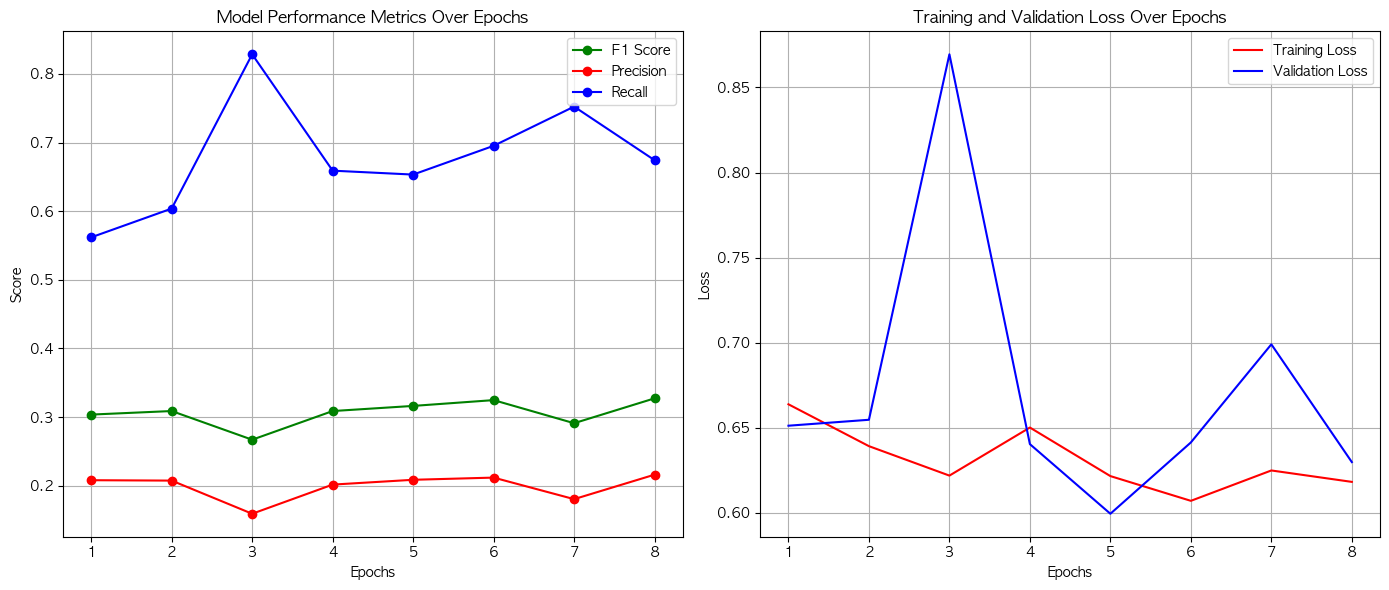

In [13]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[f1_callback, early_stopping, model_checkpoint_callback],
    class_weight=class_weight_dict,  # 클래스 가중치 사용
    verbose=2
)

# 학습 완료 후 지표 플로팅
f1_callback.plot_metrics()

In [14]:
# 모델 예측
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

# 양성으로 예측된 샘플의 인덱스 추출
positive_indices = np.where(predicted_labels == 1)[0]
positive_actual_indices = indices_test[positive_indices]
positive_predicted_labels = predicted_labels[positive_indices]

# df의 인덱스를 재조정하여 일관성 유지
df.reset_index(inplace=True, drop=True)

# 원본 데이터에서 해당 인덱스의 'ticker'와 실제 레이블 추출
# df의 인덱스가 0부터 시작한다고 가정하여 인덱스를 매핑합니다.
try:
    positive_tickers = df.loc[positive_actual_indices, 'ticker']
    actual_labels = y_test[positive_indices]  # y_test에서 양성으로 예측된 인덱스의 실제 레이블 추출
except KeyError as e:
    print(f"An error occurred: {e}")
    print(f"Check if df indices and positive_actual_indices are correctly aligned.")

# 결과 출력
for idx, ticker, pred_label, act_label in zip(positive_actual_indices, positive_tickers, positive_predicted_labels, actual_labels):
    print(f"Original Index: {idx}, Ticker: {ticker}, Predicted: {pred_label}, Actual: {act_label}")

129/129 [==============================] - 1s 11ms/step
Original Index: 3024, Ticker: 307750, Predicted: [1], Actual: 0
Original Index: 20484, Ticker: 273060, Predicted: [1], Actual: 0
Original Index: 9814, Ticker: 210120, Predicted: [1], Actual: 0
Original Index: 7668, Ticker: 200350, Predicted: [1], Actual: 0
Original Index: 6835, Ticker: 232680, Predicted: [1], Actual: 0
Original Index: 696, Ticker: 013720, Predicted: [1], Actual: 0
Original Index: 19607, Ticker: 058970, Predicted: [1], Actual: 0
Original Index: 14173, Ticker: 232830, Predicted: [1], Actual: 0
Original Index: 19638, Ticker: 058970, Predicted: [1], Actual: 0
Original Index: 18332, Ticker: 096870, Predicted: [1], Actual: 1
Original Index: 16880, Ticker: 123750, Predicted: [1], Actual: 0
Original Index: 19833, Ticker: 058970, Predicted: [1], Actual: 1
Original Index: 5678, Ticker: 113810, Predicted: [1], Actual: 0
Original Index: 341, Ticker: 013720, Predicted: [1], Actual: 1
Original Index: 14386, Ticker: 232830, Pred

In [15]:
total_samples = 0
positive_samples = 0

# 각 ticker 별로 레이블 데이터에서 1과 0의 개수를 계산하여 타겟 비율을 확인
for sequences, labels in ticker_sequences_and_labels.values():
    total_samples += len(labels)
    positive_samples += sum(labels)

# 타겟 비율 계산
target_ratio = positive_samples / total_samples

print(f"Total samples: {total_samples}")
print(f"Positive samples: {positive_samples}")
print(f"Target ratio: {target_ratio:.2f}")

Total samples: 20640
Positive samples: 2599
Target ratio: 0.13


# LSTM(Down Sampling)

Model : LSTM

Data : KOSDAQ 2020.01.01 ~ 2024.04.30 / 2020년 1월 2일 기준 시총 100억~ 200억만 활용 <br/>
Imbalanced Data : Down sampling

Feature : '시가', '고가', '저가', '종가', '거래량'

Scaler : Standard

## Data Processing

In [29]:
# CSV 파일 불러오기
file_path = '/Users/yangdong-yeong/Desktop/Fnguide/data/kosdaq_100억~200억_scaled.csv'
ticker_df = pd.read_csv(file_path)

# '날짜' 열을 datetime 객체로 변환
ticker_df['날짜'] = pd.to_datetime(ticker_df['날짜'])

# ticker 별로 데이터 분할
tickers = ticker_df['ticker'].unique()
ticker_data = {ticker: ticker_df[ticker_df['ticker'] == ticker] for ticker in tickers}
# 시퀀스 데이터와 레이블 생성 함수
def create_sequences_and_labels(df, sequence_length, threshold=20, look_forward=30):
    sequences = []
    labels = []
    if len(df) >= sequence_length + look_forward:

        for i in range(len(df) - sequence_length - look_forward + 1):
            sequence_start = i
            sequence_end = i + sequence_length
            future_start = sequence_end
            future_end = future_start + look_forward

            sequences.append(df[['시가', '고가', '저가', '종가', '거래량']].iloc[sequence_start:sequence_end].values)
            future_data = df.iloc[future_start:future_end]
            # 등락률을 사용하여 레이블 결정
            labels.append(any(future_data['등락률'] >= threshold))

        return np.array(sequences), np.array(labels).astype(int)
    else:
        return np.array([]), np.array([])  # 데이터 포인트가 부족할 경우 빈 배열 반환
    
# 시퀀스 길이 설정
sequence_length = 180  # 과거 180일의 데이터로 시퀀스 생성
num_features = 5

# 각 ticker 별로 시퀀스와 레이블 생성
ticker_sequences_and_labels = {ticker: create_sequences_and_labels(ticker_data[ticker], sequence_length) for ticker in tickers}

# 모든 ticker의 시퀀스와 레이블을 하나의 리스트에 모으기
all_sequences = []
all_labels = []

for ticker, (sequences, labels) in ticker_sequences_and_labels.items():
    if sequences.size > 0:
        all_sequences.append(sequences)
        all_labels.append(labels)

# 배열로 변환
if all_sequences:
    all_sequences = np.concatenate(all_sequences)
    all_labels = np.concatenate(all_labels)
else:
    all_sequences, all_labels = np.array([]), np.array([])

print(f"Combined Sequences Shape: {all_sequences.shape if all_sequences.size > 0 else 'No sequences available'}")
print(f"Combined Labels Shape: {all_labels.shape if all_labels.size > 0 else 'No labels available'}")

Combined Sequences Shape: (20640, 180, 5)
Combined Labels Shape: (20640,)


In [38]:
# 데이터 불균형 해결을 위한 다운샘플링
# 1인 레이블과 0인 레이블 분리
positive_indices = np.where(all_labels == 1)[0]
negative_indices = np.where(all_labels == 0)[0]

# 1인 레이블의 수를 기준으로 0인 레이블의 수 조정
np.random.seed(42)
downsampled_negative_indices = np.random.choice(negative_indices, size=len(positive_indices), replace=False)

# 다운샘플링된 인덱스 결합
downsampled_indices = np.concatenate([positive_indices, downsampled_negative_indices])

# 다운샘플링된 데이터 추출
X_downsampled = all_sequences[downsampled_indices]
y_downsampled = all_labels[downsampled_indices]

In [39]:
# 데이터 분할
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X_downsampled, y_downsampled, np.arange(X_downsampled.shape[0]), test_size=0.2, random_state=42)

In [40]:

# 체크포인트를 저장할 경로 설정
checkpoint_path = '/Users/yangdong-yeong/Desktop/Fnguide/Check_Point/model_100~200_Downsample_scaled{epoch:02d}-{val_loss:.2f}.h5'

# F1 Score 콜백 정의
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.precision_scores = []
        self.recall_scores = []
        self.f1_scores = []
        self.train_losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = (self.model.predict(self.X_val) > 0.5).astype(int)
        val_targ = self.y_val
        precision = precision_score(val_targ, val_predict, zero_division=0)
        recall = recall_score(val_targ, val_predict, zero_division=0)
        f1 = f1_score(val_targ, val_predict, zero_division=0)

        # Store the precision, recall, and f1 scores
        self.precision_scores.append(precision)
        self.recall_scores.append(recall)
        self.f1_scores.append(f1)

        # Store the train and validation loss
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

    def plot_metrics(self):
        epochs = range(1, len(self.f1_scores) + 1)
        
        # Plot F1, Precision, and Recall
        plt.figure(figsize=(14, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.f1_scores, 'go-', label='F1 Score')
        plt.plot(epochs, self.precision_scores, 'ro-', label='Precision')
        plt.plot(epochs, self.recall_scores, 'bo-', label='Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.title('Model Performance Metrics Over Epochs')
        plt.legend()
        plt.grid(True)
        
        # Plot Loss and Validation Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_losses, 'r-', label='Training Loss')
        plt.plot(epochs, self.val_losses, 'b-', label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

Epoch 1/10
33/33 [==============================] - 1s 12ms/step
65/65 - 8s - loss: 0.6733 - accuracy: 0.5952 - precision_3: 0.6166 - recall_3: 0.4808 - val_loss: 0.6531 - val_accuracy: 0.6106 - val_precision_3: 0.6836 - val_recall_3: 0.4705 - 8s/epoch - 123ms/step
Epoch 2/10
33/33 [==============================] - 0s 12ms/step
65/65 - 3s - loss: 0.6632 - accuracy: 0.6166 - precision_3: 0.6604 - recall_3: 0.4633 - val_loss: 0.6520 - val_accuracy: 0.6279 - val_precision_3: 0.6815 - val_recall_3: 0.5369 - 3s/epoch - 39ms/step
Epoch 3/10
33/33 [==============================] - 0s 12ms/step
65/65 - 3s - loss: 0.6479 - accuracy: 0.6376 - precision_3: 0.6580 - recall_3: 0.5566 - val_loss: 0.6420 - val_accuracy: 0.6394 - val_precision_3: 0.6667 - val_recall_3: 0.6162 - 3s/epoch - 39ms/step
Epoch 4/10
33/33 [==============================] - 0s 12ms/step
65/65 - 2s - loss: 0.6258 - accuracy: 0.6474 - precision_3: 0.6545 - recall_3: 0.6087 - val_loss: 0.6114 - val_accuracy: 0.6606 - val_preci

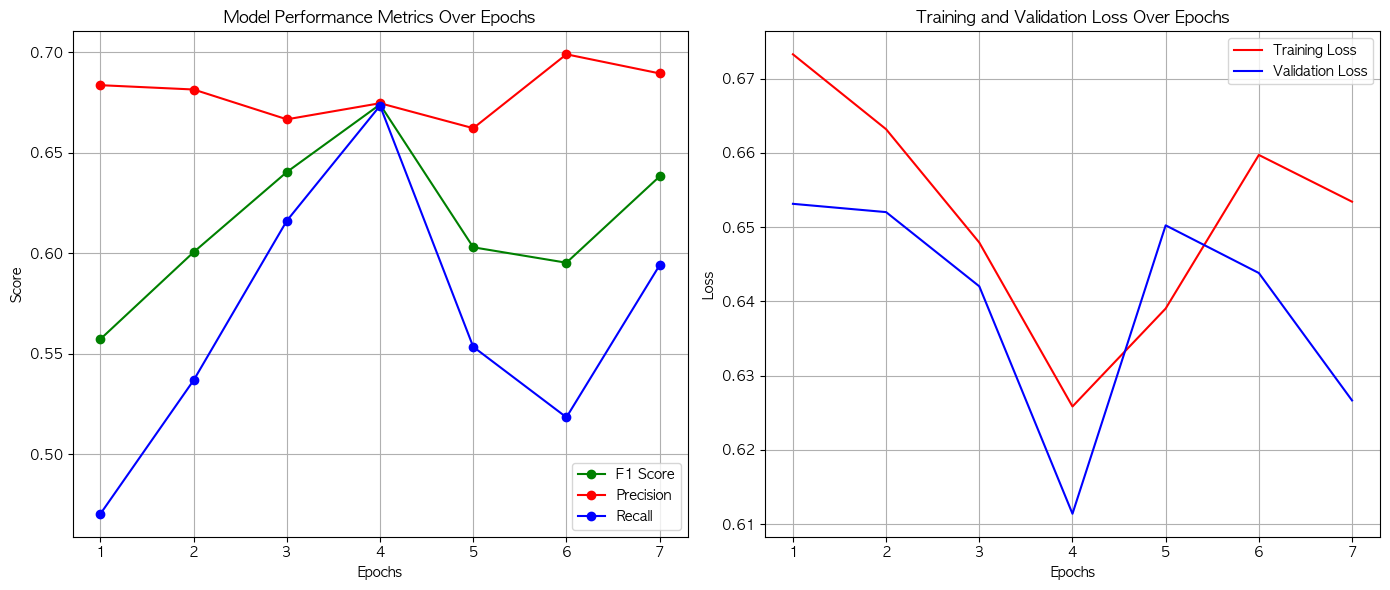

In [41]:
# LSTM 모델
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features)),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# 콜백 인스턴스 생성
f1_callback = F1ScoreCallback(X_test, y_test)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[f1_callback, early_stopping, model_checkpoint_callback],
    verbose=2
)

# 학습 완료 후 지표 플로팅
f1_callback.plot_metrics()


In [42]:
# 모델 예측
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

# 양성으로 예측된 샘플의 인덱스 추출
positive_indices = np.where(predicted_labels == 1)[0]
positive_actual_indices = indices_test[positive_indices]
positive_predicted_labels = predicted_labels[positive_indices]

# df의 인덱스를 재조정하여 일관성 유지
df.reset_index(inplace=True, drop=True)

# 원본 데이터에서 해당 인덱스의 'ticker'와 실제 레이블 추출
# df의 인덱스가 0부터 시작한다고 가정하여 인덱스를 매핑합니다.
try:
    positive_tickers = df.loc[positive_actual_indices, 'ticker']
    actual_labels = y_test[positive_indices]  # y_test에서 양성으로 예측된 인덱스의 실제 레이블 추출
except KeyError as e:
    print(f"An error occurred: {e}")
    print(f"Check if df indices and positive_actual_indices are correctly aligned.")

# 결과 출력
for idx, ticker, pred_label, act_label in zip(positive_actual_indices, positive_tickers, positive_predicted_labels, actual_labels):
    print(f"Original Index: {idx}, Ticker: {ticker}, Predicted: {pred_label}, Actual: {act_label}")

33/33 [==============================] - 0s 11ms/step
Original Index: 1334, Ticker: 222160, Predicted: [1], Actual: 1
Original Index: 79, Ticker: 013720, Predicted: [1], Actual: 1
Original Index: 4634, Ticker: 340360, Predicted: [1], Actual: 0
Original Index: 1815, Ticker: 222160, Predicted: [1], Actual: 1
Original Index: 2492, Ticker: 307750, Predicted: [1], Actual: 1
Original Index: 2114, Ticker: 222160, Predicted: [1], Actual: 1
Original Index: 3082, Ticker: 307750, Predicted: [1], Actual: 0
Original Index: 2331, Ticker: 307750, Predicted: [1], Actual: 1
Original Index: 584, Ticker: 013720, Predicted: [1], Actual: 1
Original Index: 1158, Ticker: 222160, Predicted: [1], Actual: 1
Original Index: 2807, Ticker: 307750, Predicted: [1], Actual: 0
Original Index: 3548, Ticker: 332290, Predicted: [1], Actual: 0
Original Index: 2438, Ticker: 307750, Predicted: [1], Actual: 1
Original Index: 624, Ticker: 013720, Predicted: [1], Actual: 1
Original Index: 1536, Ticker: 222160, Predicted: [1], 

In [43]:
# 다운샘플링 후 샘플 개수
total_samples = len(y_downsampled)
positive_samples = np.sum(y_downsampled)

# 타겟 비율 계산
target_ratio = positive_samples / total_samples

print(f"Total samples after downsampling: {total_samples}")
print(f"Positive samples after downsampling: {positive_samples}")
print(f"Target ratio after downsampling: {target_ratio:.2f}")


Total samples after downsampling: 5198
Positive samples after downsampling: 2599
Target ratio after downsampling: 0.50


# LSTM (TA Feature)

Model : LSTM

Data : KOSDAQ 2020.01.01 ~ 2024.04.30 / 2020년 1월 2일 기준 시총 100억~ 200억만 활용 <br/>
Imbalanced Data : Down sampling

Feature : '시가', '고가', '저가', '종가', '거래량', 'RSI', 'MACD', 'MACD_Signal',
                  'Stochastic_Oscillator', 'Bollinger_Up', 'Bollinger_Down', 'VWAP',
                  'SMA_5', 'SMA_20', 'SMA_60', 'SMA_120'

Scaler : Standard

## Data Processing

In [16]:
# 기술적 지표 정의
def compute_RSI(data, window=14):
    diff = data.diff(1).dropna()
    gain = 0 * diff
    loss = 0 * diff
    gain[diff > 0] = diff[diff > 0]
    loss[diff < 0] = -diff[diff < 0]
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    avg_loss += 1e-10  # Adjust to prevent division by zero leading to Inf
    rs = avg_gain / (avg_loss)
    rsi = 100 - (100 / (1 + rs))
    return rsi


def compute_MACD(data, span1=12, span2=26, signal_span=9):
    exp1 = data.ewm(span=span1, adjust=False).mean()
    exp2 = data.ewm(span=span2, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=signal_span, adjust=False).mean()
    return macd, signal

def compute_Stochastic_Oscillator(data, window=14):
    l14 = data['저가'].rolling(window=window).min()
    h14 = data['고가'].rolling(window=window).max()
    # Ensure no division by zero
    k = 100 * ((data['종가'] - l14) / (h14 - l14 + 1e-10))
    return k


def compute_Bollinger_Bands(data, window=20):
    sma = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()
    bollinger_up = sma + std * 2
    bollinger_down = sma - std * 2
    return bollinger_up, bollinger_down

def compute_VWAP(df):
    vwap = (df['거래량'] * (df['고가'] + df['저가'] + df['종가']) / 3).cumsum() / df['거래량'].cumsum()
    return vwap

def compute_SMA(data, windows):
    smas = {}
    for window in windows:
        smas[f'SMA_{window}'] = data.rolling(window=window).mean()
    return smas

In [17]:
# CSV 파일 불러오기
file_path = '/Users/yangdong-yeong/Desktop/Fnguide/data/kosdaq_100억~200억_scaled.csv'
ticker_df = pd.read_csv(file_path)

# '날짜' 열을 datetime 객체로 변환
ticker_df['날짜'] = pd.to_datetime(ticker_df['날짜'])

# ticker 별로 데이터 분할
tickers = ticker_df['ticker'].unique()
ticker_data = {ticker: ticker_df[ticker_df['ticker'] == ticker] for ticker in tickers}

# 기술적 지표 추가
for ticker in tickers:
    # Make a copy of the DataFrame to ensure it's not a view or slice
    data = ticker_data[ticker].copy(deep=True)
    
    # Compute and assign new columns
    data.loc[:, 'RSI'] = compute_RSI(data['종가'])
    macd, macd_signal = compute_MACD(data['종가'])
    data.loc[:, 'MACD'] = macd
    data.loc[:, 'MACD_Signal'] = macd_signal
    data.loc[:, 'Stochastic_Oscillator'] = compute_Stochastic_Oscillator(data)
    bollinger_up, bollinger_down = compute_Bollinger_Bands(data['종가'])
    data.loc[:, 'Bollinger_Up'] = bollinger_up
    data.loc[:, 'Bollinger_Down'] = bollinger_down
    data.loc[:, 'VWAP'] = compute_VWAP(data)
    
    sma_values = compute_SMA(data['종가'], [5, 20, 60, 120])
    for sma_key, sma_value in sma_values.items():
        data.loc[:, sma_key] = sma_value
    
    # Fill NaN values using the new recommended methods
    data.bfill(inplace=True)
    data.ffill(inplace=True)
    
    # Assign the modified DataFrame back to the dictionary
    ticker_data[ticker] = data

feature_columns = ['시가', '고가', '저가', '종가', '거래량', 'RSI', 'MACD', 'MACD_Signal',
                  'Stochastic_Oscillator', 'Bollinger_Up', 'Bollinger_Down', 'VWAP',
                  'SMA_5', 'SMA_20', 'SMA_60', 'SMA_120'
                  ]

# 시퀀스 데이터와 레이블 생성 함수
def create_sequences_and_labels(df, sequence_length, threshold=20, look_forward=30):
    sequences = []
    labels = []
    if len(df) >= sequence_length + look_forward:
        for i in range(len(df) - sequence_length - look_forward + 1):
            sequence_start = i
            sequence_end = i + sequence_length
            future_start = sequence_end
            future_end = future_start + look_forward
            sequences.append(df[feature_columns].iloc[sequence_start:sequence_end].values)
            future_data = df.iloc[future_start:future_end]
            labels.append(any(future_data['등락률'] >= threshold))
        return np.array(sequences), np.array(labels).astype(int)
    else:
        return np.array([]), np.array([]) # 데이터 포인트가 부족할 경우 빈 배열 반환
    
# 시퀀스 길이 설정
sequence_length = 180  # 과거 180일의 데이터로 시퀀스 생성
num_features = len(feature_columns)

# 각 ticker 별로 시퀀스와 레이블 생성
ticker_sequences_and_labels = {ticker: create_sequences_and_labels(ticker_data[ticker], sequence_length) for ticker in tickers}

# 모든 ticker의 시퀀스와 레이블을 하나의 리스트에 모으기
all_sequences = []
all_labels = []

for ticker, (sequences, labels) in ticker_sequences_and_labels.items():
    if sequences.size > 0:
        all_sequences.append(sequences)
        all_labels.append(labels)

# 배열로 변환
if all_sequences:
    all_sequences = np.concatenate(all_sequences)
    all_labels = np.concatenate(all_labels)
else:
    all_sequences, all_labels = np.array([]), np.array([])

print(f"Combined Sequences Shape: {all_sequences.shape if all_sequences.size > 0 else 'No sequences available'}")
print(f"Combined Labels Shape: {all_labels.shape if all_labels.size > 0 else 'No labels available'}")
# 데이터 불균형 해결을 위한 다운샘플링
# 1인 레이블과 0인 레이블 분리
positive_indices = np.where(all_labels == 1)[0]
negative_indices = np.where(all_labels == 0)[0]

# 1인 레이블의 수를 기준으로 0인 레이블의 수 조정
np.random.seed(42)
downsampled_negative_indices = np.random.choice(negative_indices, size=len(positive_indices), replace=False)

# 다운샘플링된 인덱스 결합
downsampled_indices = np.concatenate([positive_indices, downsampled_negative_indices])

# 다운샘플링된 데이터 추출
X_downsampled = all_sequences[downsampled_indices]
y_downsampled = all_labels[downsampled_indices]
# 데이터 분할
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X_downsampled, y_downsampled, np.arange(X_downsampled.shape[0]), test_size=0.2, random_state=42)

Combined Sequences Shape: (20640, 180, 16)
Combined Labels Shape: (20640,)


## Modeling

In [31]:
# 체크포인트를 저장할 경로 설정
checkpoint_path = '/Users/yangdong-yeong/Desktop/Fnguide/Check_Point/model_100~200_TA_Downsample_scaled{epoch:02d}-{val_loss:.2f}.h5'

# F1 Score 콜백 정의
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.precision_scores = []
        self.recall_scores = []
        self.f1_scores = []
        self.train_losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = (self.model.predict(self.X_val) > 0.5).astype(int)
        val_targ = self.y_val
        precision = precision_score(val_targ, val_predict, zero_division=0)
        recall = recall_score(val_targ, val_predict, zero_division=0)
        f1 = f1_score(val_targ, val_predict, zero_division=0)

        # Store the precision, recall, and f1 scores
        self.precision_scores.append(precision)
        self.recall_scores.append(recall)
        self.f1_scores.append(f1)

        # Store the train and validation loss
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

    def plot_metrics(self):
        epochs = range(1, len(self.f1_scores) + 1)
        
        # Plot F1, Precision, and Recall
        plt.figure(figsize=(14, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.f1_scores, 'go-', label='F1 Score')
        plt.plot(epochs, self.precision_scores, 'ro-', label='Precision')
        plt.plot(epochs, self.recall_scores, 'bo-', label='Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.title('Model Performance Metrics Over Epochs')
        plt.legend()
        plt.grid(True)
        
        # Plot Loss and Validation Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_losses, 'r-', label='Training Loss')
        plt.plot(epochs, self.val_losses, 'b-', label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        

In [32]:
# LSTM 모델
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features)),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [33]:
print(f"NaNs in training data: {np.isnan(X_train).any()}")
print(f"Infs in training data: {np.isinf(X_train).any()}")

NaNs in training data: False
Infs in training data: False


Epoch 1/15
33/33 [==============================] - 2s 14ms/step
65/65 - 8s - loss: 0.6717 - accuracy: 0.5832 - precision_3: 0.5981 - recall_3: 0.4803 - val_loss: 0.6515 - val_accuracy: 0.6365 - val_precision_3: 0.7010 - val_recall_3: 0.5277 - 8s/epoch - 130ms/step
Epoch 2/15


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 0s 13ms/step
65/65 - 3s - loss: 0.6154 - accuracy: 0.6638 - precision_3: 0.6811 - recall_3: 0.6023 - val_loss: 0.5809 - val_accuracy: 0.7106 - val_precision_3: 0.7684 - val_recall_3: 0.6365 - 3s/epoch - 48ms/step
Epoch 3/15


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 0s 13ms/step
65/65 - 3s - loss: 0.5314 - accuracy: 0.7352 - precision_3: 0.7159 - recall_3: 0.7705 - val_loss: 0.5505 - val_accuracy: 0.7260 - val_precision_3: 0.7110 - val_recall_3: 0.7989 - 3s/epoch - 47ms/step
Epoch 4/15


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 0s 13ms/step
65/65 - 3s - loss: 0.4892 - accuracy: 0.7653 - precision_3: 0.7449 - recall_3: 0.7992 - val_loss: 0.4568 - val_accuracy: 0.7731 - val_precision_3: 0.7500 - val_recall_3: 0.8469 - 3s/epoch - 49ms/step
Epoch 5/15


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 0s 13ms/step
65/65 - 3s - loss: 0.4531 - accuracy: 0.7864 - precision_3: 0.7771 - recall_3: 0.7968 - val_loss: 0.4123 - val_accuracy: 0.8029 - val_precision_3: 0.8092 - val_recall_3: 0.8137 - 3s/epoch - 47ms/step
Epoch 6/15


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 0s 13ms/step
65/65 - 3s - loss: 0.3986 - accuracy: 0.8261 - precision_3: 0.8235 - recall_3: 0.8255 - val_loss: 0.3974 - val_accuracy: 0.8115 - val_precision_3: 0.7818 - val_recall_3: 0.8856 - 3s/epoch - 47ms/step
Epoch 7/15


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 0s 13ms/step
65/65 - 3s - loss: 0.4052 - accuracy: 0.8211 - precision_3: 0.8101 - recall_3: 0.8337 - val_loss: 0.4123 - val_accuracy: 0.8077 - val_precision_3: 0.8000 - val_recall_3: 0.8413 - 3s/epoch - 48ms/step
Epoch 8/15
33/33 [==============================] - 0s 13ms/step
65/65 - 3s - loss: 0.3920 - accuracy: 0.8215 - precision_3: 0.8037 - recall_3: 0.8459 - val_loss: 0.3877 - val_accuracy: 0.8269 - val_precision_3: 0.8352 - val_recall_3: 0.8321 - 3s/epoch - 48ms/step
Epoch 9/15


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 0s 13ms/step
65/65 - 3s - loss: 0.3473 - accuracy: 0.8504 - precision_3: 0.8445 - recall_3: 0.8551 - val_loss: 0.3813 - val_accuracy: 0.8317 - val_precision_3: 0.8158 - val_recall_3: 0.8745 - 3s/epoch - 49ms/step
Epoch 10/15


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 0s 13ms/step
65/65 - 3s - loss: 0.3635 - accuracy: 0.8430 - precision_3: 0.8472 - recall_3: 0.8328 - val_loss: 0.4221 - val_accuracy: 0.8144 - val_precision_3: 0.8286 - val_recall_3: 0.8118 - 3s/epoch - 48ms/step
Epoch 11/15
33/33 [==============================] - 0s 13ms/step
65/65 - 3s - loss: 0.3584 - accuracy: 0.8427 - precision_3: 0.8273 - recall_3: 0.8619 - val_loss: 0.3342 - val_accuracy: 0.8490 - val_precision_3: 0.8767 - val_recall_3: 0.8266 - 3s/epoch - 48ms/step
Epoch 12/15


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 0s 13ms/step
65/65 - 3s - loss: 0.3159 - accuracy: 0.8624 - precision_3: 0.8589 - recall_3: 0.8639 - val_loss: 0.2988 - val_accuracy: 0.8702 - val_precision_3: 0.8921 - val_recall_3: 0.8542 - 3s/epoch - 48ms/step
Epoch 13/15


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 0s 13ms/step
65/65 - 3s - loss: 0.3146 - accuracy: 0.8617 - precision_3: 0.8594 - recall_3: 0.8614 - val_loss: 0.2850 - val_accuracy: 0.8779 - val_precision_3: 0.8952 - val_recall_3: 0.8672 - 3s/epoch - 48ms/step
Epoch 14/15


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 0s 13ms/step
65/65 - 3s - loss: 0.2882 - accuracy: 0.8814 - precision_3: 0.8818 - recall_3: 0.8780 - val_loss: 0.2952 - val_accuracy: 0.8731 - val_precision_3: 0.8839 - val_recall_3: 0.8708 - 3s/epoch - 48ms/step
Epoch 15/15
33/33 [==============================] - 0s 14ms/step
65/65 - 3s - loss: 0.3491 - accuracy: 0.8603 - precision_3: 0.8373 - recall_3: 0.8906 - val_loss: 0.3577 - val_accuracy: 0.8548 - val_precision_3: 0.8600 - val_recall_3: 0.8616 - 3s/epoch - 47ms/step


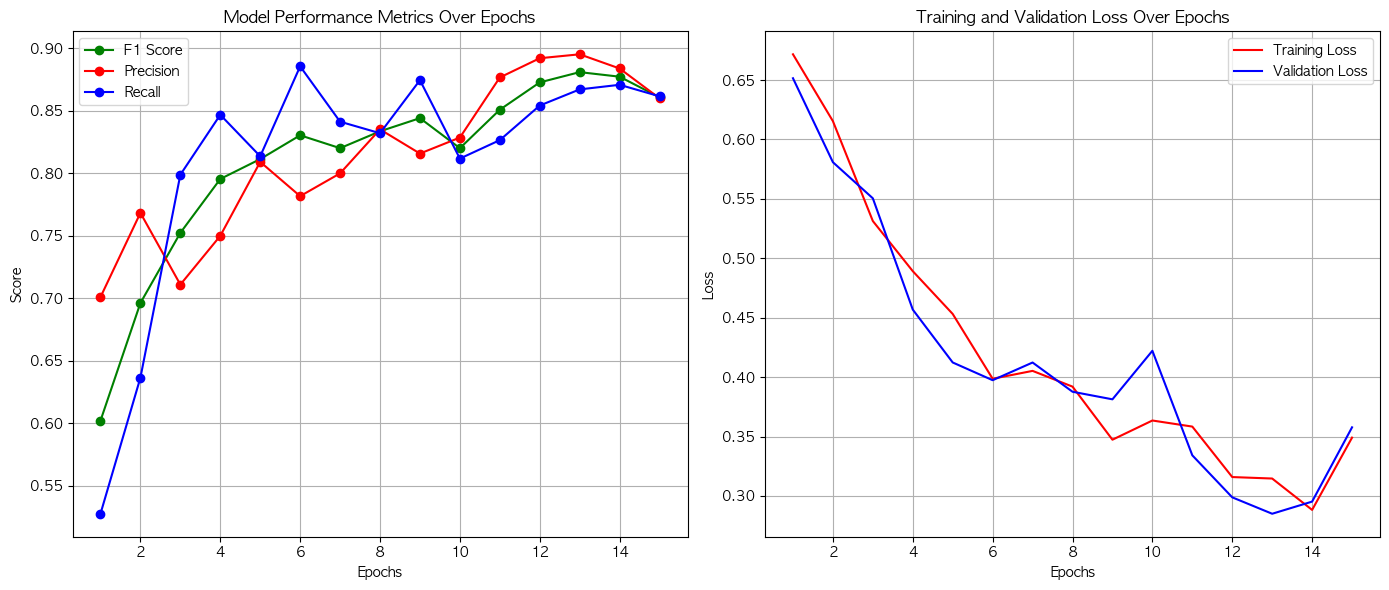

In [34]:
# 콜백 인스턴스 생성
f1_callback = F1ScoreCallback(X_test, y_test)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[f1_callback, early_stopping, model_checkpoint_callback],
    verbose=2
)

# 학습 완료 후 지표 플로팅
f1_callback.plot_metrics()

In [36]:
final_model_path = '/Users/yangdong-yeong/Desktop/Fnguide/Check_Point/LSTM_100억~200억.h5'
model.save(final_model_path)
print(f"Model saved to {final_model_path}")

Model saved to /Users/yangdong-yeong/Desktop/Fnguide/Check_Point/LSTM_100억~200억.h5


# Test

## Data : 200억 ~ 300억

시가총액 200억~300억 데이터로 Model Test

## Load and Prepare the New Dataset

In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

file_path = '/Users/yangdong-yeong/Desktop/Fnguide/data/kosdaq_200억~300억_scaled.csv'
ticker_df = pd.read_csv(file_path)

# '날짜' 열을 datetime 객체로 변환
ticker_df['날짜'] = pd.to_datetime(ticker_df['날짜'])

# ticker 별로 데이터 분할
tickers = ticker_df['ticker'].unique()
ticker_data = {ticker: ticker_df[ticker_df['ticker'] == ticker] for ticker in tickers}

# 기술적 지표 추가
for ticker in tickers:
    # Make a copy of the DataFrame to ensure it's not a view or slice
    data = ticker_data[ticker].copy(deep=True)
    
    # Compute and assign new columns
    data.loc[:, 'RSI'] = compute_RSI(data['종가'])
    macd, macd_signal = compute_MACD(data['종가'])
    data.loc[:, 'MACD'] = macd
    data.loc[:, 'MACD_Signal'] = macd_signal
    data.loc[:, 'Stochastic_Oscillator'] = compute_Stochastic_Oscillator(data)
    bollinger_up, bollinger_down = compute_Bollinger_Bands(data['종가'])
    data.loc[:, 'Bollinger_Up'] = bollinger_up
    data.loc[:, 'Bollinger_Down'] = bollinger_down
    data.loc[:, 'VWAP'] = compute_VWAP(data)
    
    sma_values = compute_SMA(data['종가'], [5, 20, 60, 120])
    for sma_key, sma_value in sma_values.items():
        data.loc[:, sma_key] = sma_value
    
    # Fill NaN values using the new recommended methods
    data.bfill(inplace=True)
    data.ffill(inplace=True)
    
    # Assign the modified DataFrame back to the dictionary
    ticker_data[ticker] = data

# Feature columns remain the same as you trained your model with these features
feature_columns = [
    '시가', '고가', '저가', '종가', '거래량', 
    'RSI', 'MACD', 'MACD_Signal', 
    'Stochastic_Oscillator', 'Bollinger_Up', 'Bollinger_Down', 
    'VWAP', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_120'
]

# Create sequences for the new dataset
sequence_length = 180

new_sequences = []
new_labels = []

for ticker in tickers:
    df = ticker_data[ticker]
    if len(df) >= sequence_length:
        seqs, labs = create_sequences_and_labels(df, sequence_length)
        new_sequences.append(seqs)
        new_labels.append(labs)

if new_sequences:
    new_sequences = np.concatenate(new_sequences)
    new_labels = np.concatenate(new_labels)
else:
    new_sequences, new_labels = np.array([]), np.array([])

print(f"New Sequences Shape: {new_sequences.shape if new_sequences.size > 0 else 'No sequences available'}")
print(f"New Labels Shape: {new_labels.shape if new_labels.size > 0 else 'No labels available'}")


New Sequences Shape: (48160, 180, 16)
New Labels Shape: (48160,)


## Load the Trained Model and Predict

In [38]:
# Load the trained model - replace this path with the path to your saved model
model_path = '/Users/yangdong-yeong/Desktop/Fnguide/Check_Point/LSTM_100억~200억.h5'
model = load_model(model_path)

# Predict on the new data
predictions = model.predict(new_sequences)
predicted_labels = (predictions > 0.5).astype(int)


1505/1505 [==============================] - 21s 13ms/step


## Evaluate the Model Performance

In [39]:
from sklearn.metrics import accuracy_score

# Actual labels are new_labels
actual_labels = new_labels

# Calculate performance metrics
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, zero_division=0)
recall = recall_score(actual_labels, predicted_labels, zero_division=0)
f1 = f1_score(actual_labels, predicted_labels, zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.7511
Precision: 0.1354
Recall: 0.2657
F1 Score: 0.1794
